In [8]:
%matplotlib inline
import pyspark
import pyspark.ml
from pyspark.sql.functions import *
from pyspark.ml.feature import RFormula
from pyspark.ml.classification import LogisticRegression


spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [2]:
swiss = spark.read.csv('swiss.txt', header=True, inferSchema=True)
swiss.show()

+---------+-----------+-----------+---------+--------+----------------+
|fertility|agriculture|examination|education|catholic|infant_mortality|
+---------+-----------+-----------+---------+--------+----------------+
|     80.2|       17.0|         15|       12|    9.96|            22.2|
|     83.1|       45.1|          6|        9|   84.84|            22.2|
|     92.5|       39.7|          5|        5|    93.4|            20.2|
|     85.8|       36.5|         12|        7|   33.77|            20.3|
|     76.9|       43.5|         17|       15|    5.16|            20.6|
|     76.1|       35.3|          9|        7|   90.57|            26.6|
|     83.8|       70.2|         16|        7|   92.85|            23.6|
|     92.4|       67.8|         14|        8|   97.16|            24.9|
|     82.4|       53.3|         12|        7|   97.67|            21.0|
|     82.9|       45.2|         16|       13|   91.38|            24.4|
|     87.1|       64.5|         14|        6|   98.61|          

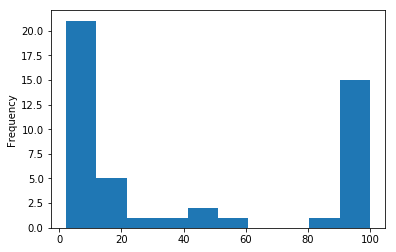

In [3]:
swiss.toPandas().catholic.plot.hist()


In [4]:
swiss = (swiss
 .withColumn('is_catholic', when(swiss.catholic > 60, 'Catholic').otherwise('Not Catholic'))
 .drop('catholic'))

In [5]:
swiss.show()


+---------+-----------+-----------+---------+----------------+------------+
|fertility|agriculture|examination|education|infant_mortality| is_catholic|
+---------+-----------+-----------+---------+----------------+------------+
|     80.2|       17.0|         15|       12|            22.2|Not Catholic|
|     83.1|       45.1|          6|        9|            22.2|    Catholic|
|     92.5|       39.7|          5|        5|            20.2|    Catholic|
|     85.8|       36.5|         12|        7|            20.3|Not Catholic|
|     76.9|       43.5|         17|       15|            20.6|Not Catholic|
|     76.1|       35.3|          9|        7|            26.6|    Catholic|
|     83.8|       70.2|         16|        7|            23.6|    Catholic|
|     92.4|       67.8|         14|        8|            24.9|    Catholic|
|     82.4|       53.3|         12|        7|            21.0|    Catholic|
|     82.9|       45.2|         16|       13|            24.4|    Catholic|
|     87.1| 

In [6]:
rf = RFormula(formula='is_catholic ~ agriculture + examination')

df = rf.fit(swiss).transform(swiss).select('features', 'label')

In [7]:
df.show(5)


+-----------+-----+
|   features|label|
+-----------+-----+
|[17.0,15.0]|  0.0|
| [45.1,6.0]|  1.0|
| [39.7,5.0]|  1.0|
|[36.5,12.0]|  0.0|
|[43.5,17.0]|  0.0|
+-----------+-----+
only showing top 5 rows



### Classify with Logistic Regression Model
### We classify with a binary prediction of their precinct is Catholic or is not Catholic.

In [9]:
lr = LogisticRegression()
lr_fit = lr.fit(df)
lr_fit

LogisticRegressionModel: uid = LogisticRegression_f89f34bf71e3, numClasses = 2, numFeatures = 2

In [10]:
(lr_fit.transform(df)
 .withColumn('we_got_it_right', col('label') == col('prediction'))).show()

+-----------+-----+--------------------+--------------------+----------+---------------+
|   features|label|       rawPrediction|         probability|prediction|we_got_it_right|
+-----------+-----+--------------------+--------------------+----------+---------------+
|[17.0,15.0]|  0.0|[2.61081360006245...|[0.93155429036120...|       0.0|           true|
| [45.1,6.0]|  1.0|[-1.9844861732885...|[0.12084142107894...|       1.0|           true|
| [39.7,5.0]|  1.0|[-2.1417946363626...|[0.10510047647313...|       1.0|           true|
|[36.5,12.0]|  0.0|[0.65897957038476...|[0.65903112585454...|       0.0|           true|
|[43.5,17.0]|  0.0|[2.27460235659845...|[0.90675166037879...|       0.0|           true|
| [35.3,9.0]|  1.0|[-0.4347561719699...|[0.39299117537033...|       1.0|           true|
|[70.2,16.0]|  1.0|[0.78661973782068...|[0.68710506231533...|       0.0|          false|
|[67.8,14.0]|  1.0|[0.12378901391833...|[0.53090779502300...|       0.0|          false|
|[53.3,12.0]|  1.0|[-

In [11]:
training_summary = lr_fit.summary


In [12]:
training_summary.areaUnderROC



0.9314516129032259

In [13]:
training_summary.accuracy


0.8723404255319149

### Linear Regression

In [14]:

rf = RFormula(formula='fertility ~ education + examination')

df = (rf.fit(swiss)
 .transform(swiss)
 .select('features', 'label'))

df.show(5)

+-----------+-----+
|   features|label|
+-----------+-----+
|[12.0,15.0]| 80.2|
|  [9.0,6.0]| 83.1|
|  [5.0,5.0]| 92.5|
| [7.0,12.0]| 85.8|
|[15.0,17.0]| 76.9|
+-----------+-----+
only showing top 5 rows



In [15]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression()
lr_fit = lr.fit(df)
lr_fit.transform(df).show()

+-----------+-----+------------------+
|   features|label|        prediction|
+-----------+-----+------------------+
|[12.0,15.0]| 80.2| 70.42151794297953|
|  [9.0,6.0]| 83.1| 77.05485310331413|
|  [5.0,5.0]| 92.5| 79.76989921395041|
| [7.0,12.0]| 85.8| 74.79045752192646|
|[15.0,17.0]| 76.9| 67.68871054525121|
|  [7.0,9.0]| 76.1| 76.46211227732914|
| [7.0,16.0]| 83.8| 72.56158451472288|
| [8.0,14.0]| 92.4| 73.13656405361581|
| [7.0,12.0]| 82.4| 74.79045752192646|
|[13.0,16.0]| 82.9|  69.3248427264698|
| [6.0,14.0]| 87.1| 74.21547798303351|
|[12.0,21.0]| 64.1| 67.07820843217418|
| [7.0,14.0]| 66.9| 73.67602101832466|
|[12.0,19.0]| 68.9| 68.19264493577596|
| [5.0,22.0]| 61.7|  70.2971889333352|
| [2.0,18.0]| 68.3| 74.14443283466532|
| [8.0,17.0]| 71.7| 71.46490929821314|
|[28.0,26.0]| 55.7|55.660805737828156|
|[20.0,31.0]| 54.3| 57.19037019649446|
| [9.0,19.0]| 65.1|  69.8110158299025|
+-----------+-----+------------------+
only showing top 20 rows



In [16]:
training_summary = lr_fit.summary
training_summary.r2, training_summary.rootMeanSquaredError

(0.5054845186373219, 8.69043227803294)